# Behavioral Data Analysis

This notebook generates timecourse analyses and figures for experiments 1 and 2.

### Imports

In [1]:
import pandas as pd; import seaborn as sb; import warnings; import pingouin; import scipy; import re; import os
import pingouin; from analysis_helpers import *; import itertools; from scipy import stats
import random
warnings.filterwarnings('ignore')
%matplotlib inline

### Load Data

In [2]:
exp1 = pd.DataFrame.from_csv('/Users/kirstenziman/Desktop/new_place/attention-memory-task/Experiment1_BlockCue/code/parsed_data/behavioral_data_exp1.csv')
exp2 = pd.DataFrame.from_csv('/Users/kirstenziman/Desktop/new_place/attention-memory-task/Experiment2_TrialCue/code/analysis/behavioral.csv')

In [3]:
# exp2 = exp2.replace(to_replace='Nov_Cued', value='Novel')
# exp2 = exp2.replace(to_replace='Nov_Un', value='Novel')

In [4]:
#exp2[exp2['Subject']==28]

In [5]:
#exp2[exp2['Subject']==3][['Memory Image','Attention Level','Category']] #.groupby(['Attention Level','Category']).mean()

# Data Organize

In [6]:
#list(range(0,40))

In [7]:
# Make sure all images labeled by their inherent category (use image filename)
exp2.ix[ exp2['Memory Image'].str.contains("sun", na=False),'Category']='Place'
exp2.ix[~exp2['Memory Image'].str.contains("sun", na=False),'Category']='Face'
exp2.loc[exp2['Trial Type']=='Presentation','Category']=np.nan

# Make sure all memory trials are numbered
exp1.loc[exp1['Trial Type']=='Memory','Trial'] = list(range(0,40))*30*8
exp2.loc[exp2['Trial Type']=='Memory','Trial'] = list(range(0,40))*30*8

In [8]:
exp2[exp2['Subject']==28].groupby(['Attention Level','Category']).mean()

Unnamed: 0.1  Subject  Run  \
Attention Level Category                               
Category        Face        204.300000     28.0  3.5   
                Place       207.600000     28.0  3.5   
Full            Face        207.233333     28.0  3.5   
                Place       200.600000     28.0  3.5   
None            Face        211.000000     28.0  3.5   
                Place       204.233333     28.0  3.5   
Nov_Cued        Place       201.800000     28.0  3.5   
Nov_Un          Face        205.175000     28.0  3.5   
Side            Face        206.200000     28.0  3.5   
                Place       205.166667     28.0  3.5   

                          Attention Reaction Time (s)  \
Attention Level Category                                
Category        Face                              NaN   
                Place                             NaN   
Full            Face                              NaN   
                Place                             NaN   
None            Face                              NaN   
                Place                             NaN   
Nov_Cued        Place                             NaN   
Nov_Un          Face                              NaN   
Side            Face                              NaN   
                Place                             NaN   

                          Familiarity Reaction Time (s)  Familiarity Rating  \
Attention Level Category                                                      
Category        Face                           1.050233            1.551724   
                Place                          1.517800            1.900000   
Full            Face                           1.088600            1.566667   
                Place                          1.322200            3.000000   
None            Face                           1.215800            2.000000   
                Place                          1.322000            2.000000   
Nov_Cued        Place                          1.306925            2.225000   
Nov_Un          Face                           1.155875            1.587500   
Side            Face                           0.955300            2.111111   
                Place                          1.269967            2.000000   

                          Cue Validity  Post Invalid Cue  Pre Invalid Cue  \
Attention Level Category                                                    
Category        Face               NaN               NaN              NaN   
                Place              NaN               NaN              NaN   
Full            Face               NaN               NaN              NaN   
                Place              NaN               NaN              NaN   
None            Face               NaN               NaN              NaN   
                Place              NaN               NaN              NaN   
Nov_Cued        Place              NaN               NaN              NaN   
Nov_Un          Face               NaN               NaN              NaN   
Side            Face               NaN               NaN              NaN   
                Place              NaN               NaN              NaN   

                          Attention Button  Rating History  Stimulus Onset  \
Attention Level Category                                                     
Category        Face                   NaN             NaN    1.556031e+09   
                Place                  NaN             NaN    1.556031e+09   
Full            Face                   NaN             NaN    1.556031e+09   
                Place                  NaN             NaN    1.556031e+09   
None            Face                   NaN             NaN    1.556031e+09   
                Place                  NaN             NaN    1.556031e+09   
Nov_Cued        Place                  NaN             NaN    1.556031e+09   
Nov_Un          Face                   NaN             NaN    1.556031e+09   
Side          

### Exp2: add column for the last-cued category before each memory block

In [9]:
exp2['Last Cued'] = np.nan

for sub in exp2['Subject'].unique():
    for run in exp2['Run'].unique():
        
        # obtain cued category from the last presentation trial
        last_cat = exp2[(exp2['Trial Type']=='Presentation')
                       & (exp2['Subject']==sub)
                       & (exp2['Run']==run)
                       & (exp2['Trial']==9)]['Cued Category'].item()
        # print(last_cat)
        
        # assign to this memory run
        exp2.loc[(exp2['Trial Type']=='Memory')
                       & (exp2['Subject']==sub)
                       & (exp2['Run']==run),'Last Cued'] = last_cat

### Re-Label Novel Images by Cued or Uncued category

In [10]:
exp1 = add_nov_label(exp1)
exp2 = add_nov_label(exp2, column_name ='Last Cued')

In [11]:
exp2[(exp2['Subject']==28) & (exp2['Trial Type']=='Presentation') & (exp2['Trial']==9)]['Cued Category']

#  & (exp2['Trial']==35)]      


#.  .groupby(['Attention Level','Category']).mean()

9     Place
19    Place
29    Place
39    Place
49    Place
59    Place
69    Place
79    Place
Name: Cued Category, dtype: object

# Plot Data

### Apply Sliding Window

In [12]:
window_length = 20

In [13]:
# exp1_mean_window

In [14]:
exp1_mean_window = apply_window(exp1, window_length)

exp2_mean_window = apply_window(exp2, window_length)

### Prepare data for plotting

In [15]:
plot_data={}

for data,key in zip([exp1_mean_window, exp2_mean_window],['exp1','exp2']):
    
    # average across all trials within each subject
    group = data.reset_index().groupby(['Subject','Trial']).mean()
    
    # melt/restructure the data
    group_melt = pd.melt(group.reset_index(), id_vars=['Subject','Trial'], 
                         value_vars=['Category', 'Full','None','Nov_Un', 'Nov_Cued','Side'])
                           #value_vars=['Category', 'Full','None','Nov_Cued','Nov_Un','Side'])
    
    # assign data to dictionary key
    plot_data[key] = group_melt

In [16]:
# plot_data['exp1'][plot_data['exp1']['Attention Level']=='Novel'].head()

In [17]:
plot_data['exp1']['Attention Level'].unique()

array(['Category', 'Full', 'None', 'Nov_Un', 'Nov_Cued', 'Side'],
      dtype=object)

# Plot Data !

### Mean Familiarity By Attention Level

Cued category    -->  warm colors <br/>
Uncued category  -->  cool colors

In [18]:
palette = sb.color_palette("RdBu", 20) #

# New stats

### Compare Fully Attended Images to all Other images

In [19]:
Fulls  = []
Others = []

for d,label in zip([exp1, exp2],['Experiment_1', 'Experiment_2']):
    
    for s in d['Subject'].unique():
        
        Fulls.append(d[(d['Subject']==s)&(d['Attention Level']=='Full')]['Familiarity Rating'].mean())
        Others.append(d[(d['Subject']==s) &(d['Attention Level']!='Full')]['Familiarity Rating'].mean())
        
    print(label)
    print(scipy.stats.ttest_rel(Fulls, Others))
    print()

Experiment_1
Ttest_relResult(statistic=9.396112809093742, pvalue=2.6596964490466333e-10)

Experiment_2
Ttest_relResult(statistic=9.303189339341236, pvalue=3.5822091113881163e-13)



### Attended Category versus Unattended Category images

In [20]:
att   = []
unatt = []

for d,label in zip([exp1, exp2],['Experiment_1', 'Experiment_2']):
    
    for s in d['Subject'].unique():
        
        att.append(d[(d['Subject']==s)&(d['Attention Level'].isin(['Full','Category']))]['Familiarity Rating'].mean())
        unatt.append(d[(d['Subject']==s) &(d['Attention Level'].isin(['Side','None']))]['Familiarity Rating'].mean())
        
    print(label)
    print(scipy.stats.ttest_rel(att, unatt))
    print()

Experiment_1
Ttest_relResult(statistic=6.489893651111426, pvalue=4.193385679483794e-07)

Experiment_2
Ttest_relResult(statistic=4.369524507294699, pvalue=5.115246170096461e-05)



# Category versus novel diffs

In [21]:
# Exp 1: mean(Side & Full) - mean(Novel)
 
# versus
 
# Exp 2: mean(Side & Full) - mean(Novel)

In [22]:
diffs = []
sides = []

for d,label in zip([exp1, exp2],['Experiment_1', 'Experiment_2']):
    
    cat_nov = []
    side_nov = []
    side_single = []
    
    for s in d['Subject'].unique():
        
        
        f_s_c = d[(d['Subject']==s)&(d['Attention Level'].isin(['Side','Full']))]['Familiarity Rating'].mean()
        f_s_n = d[(d['Subject']==s)&(d['Attention Level'].isin(['Category', 'Full']))]['Familiarity Rating'].mean()
        # nov = d[(d['Subject']==s) &(d['Attention Level']=='Novel')]['Familiarity Rating'].mean()
        
#         cat_nov.append(cat - nov)
#         side_nov.append(side - nov)
#         side_single.append(side)
        
    print('first set: ')
    print(len(cat_nov))
    print(len(side_nov))
        
        
    print(label)
    print(scipy.stats.ttest_rel(cat_nov, side_nov))
    print()
    
    sides.append(side_single)
    diff = [x-y for x,y in zip(cat_nov,side_nov)]
    diffs.append(diff)
    
    print(len(diff))
    

first set: 
0
0
Experiment_1
(nan, nan)

0
first set: 
0
0
Experiment_2
(nan, nan)

0


In [23]:
a_s = []
b_s = []

for d,label in zip([exp1, exp2],['Experiment_1', 'Experiment_2']):
    
    cat_nov = []
    side_nov = []
    
    for s in d['Subject'].unique():
        
        a = d[(d['Subject']==s)&(d['Attention Level'].isin(['Side','Full','Cat']))]['Familiarity Rating'].mean()
        b = d[(d['Subject']==s)&(d['Attention Level'].isin(['Side', 'Full','None']))]['Familiarity Rating'].mean()
        #nov = d[(d['Subject']==s) &(d['Attention Level']=='Novel')]['Familiarity Rating'].mean()
        
        a_s.append(a)
        b_s.append(b)
        
    print('first set: ')
    print(len(a_s))
    print(len(b_s))
        
        
    print(label)
    print(scipy.stats.ttest_rel(a_s, b_s))
    print()
    


first set: 
30
30
Experiment_1
Ttest_relResult(statistic=8.97100971289351, pvalue=7.300903452759381e-10)

first set: 
60
60
Experiment_2
Ttest_relResult(statistic=8.06178853408996, pvalue=4.301997302344965e-11)



In [24]:
diffs = []
sides = []

for d,label in zip([exp1, exp2],['Experiment_1', 'Experiment_2']):
    
    cat_nov = []
    side_nov = []
    side_single = []
    
    for s in d['Subject'].unique():
        
        
        side = d[(d['Subject']==s)&(d['Attention Level'].isin(['Side','Full']))]['Familiarity Rating'].mean()
        cat = d[(d['Subject']==s)&(d['Attention Level'].isin(['Category', 'Full']))]['Familiarity Rating'].mean()
        nov = d[(d['Subject']==s) &(d['Attention Level']=='Novel')]['Familiarity Rating'].mean()
        
        cat_nov.append(cat - nov)
        side_nov.append(side - nov)
        side_single.append(side)
        
    print('first set: ')
    print(len(cat_nov))
    print(len(side_nov))
        
        
    print(label)
    print(scipy.stats.ttest_rel(cat_nov, side_nov))
    print()
    
    sides.append(side_single)
    diff = [x-y for x,y in zip(cat_nov,side_nov)]
    diffs.append(diff)
    
    print(len(diff))
    

first set: 
30
30
Experiment_1
Ttest_relResult(statistic=nan, pvalue=nan)

30
first set: 
30
30
Experiment_2
Ttest_relResult(statistic=nan, pvalue=nan)

30


In [25]:
scipy.stats.ttest_rel(diffs[0], diffs[1])

Ttest_relResult(statistic=nan, pvalue=nan)

In [26]:
# sides

In [27]:
scipy.stats.ttest_rel(sides[1], sides[0])

Ttest_relResult(statistic=1.6218439113979923, pvalue=0.11566020459524552)

# Novel Image diffs

In [28]:
for d in [exp1, exp2]:
    
    d = d.groupby(['Subject','Attention Level'], as_index=False).mean()
    
    print(scipy.stats.ttest_rel(d[d['Attention Level']=='Nov_Cued']['Familiarity Rating'], 
                                d[d['Attention Level']=='Nov_Un']['Familiarity Rating']))
    

Ttest_relResult(statistic=5.644488500528174, pvalue=4.241252223029619e-06)
Ttest_relResult(statistic=0.22263341929217778, pvalue=0.8253814425522065)


In [29]:
exp2[exp2['Subject']==28].groupby(['Attention Level','Category']).mean()

Unnamed: 0.1  Subject  Run  \
Attention Level Category                               
Category        Face        204.300000     28.0  3.5   
                Place       207.600000     28.0  3.5   
Full            Face        207.233333     28.0  3.5   
                Place       200.600000     28.0  3.5   
None            Face        211.000000     28.0  3.5   
                Place       204.233333     28.0  3.5   
Nov_Cued        Place       201.800000     28.0  3.5   
Nov_Un          Face        205.175000     28.0  3.5   
Side            Face        206.200000     28.0  3.5   
                Place       205.166667     28.0  3.5   

                          Attention Reaction Time (s)  \
Attention Level Category                                
Category        Face                              NaN   
                Place                             NaN   
Full            Face                              NaN   
                Place                             NaN   
None            Face                              NaN   
                Place                             NaN   
Nov_Cued        Place                             NaN   
Nov_Un          Face                              NaN   
Side            Face                              NaN   
                Place                             NaN   

                          Familiarity Reaction Time (s)  Familiarity Rating  \
Attention Level Category                                                      
Category        Face                           1.050233            1.551724   
                Place                          1.517800            1.900000   
Full            Face                           1.088600            1.566667   
                Place                          1.322200            3.000000   
None            Face                           1.215800            2.000000   
                Place                          1.322000            2.000000   
Nov_Cued        Place                          1.306925            2.225000   
Nov_Un          Face                           1.155875            1.587500   
Side            Face                           0.955300            2.111111   
                Place                          1.269967            2.000000   

                          Cue Validity  Post Invalid Cue  Pre Invalid Cue  \
Attention Level Category                                                    
Category        Face               NaN               NaN              NaN   
                Place              NaN               NaN              NaN   
Full            Face               NaN               NaN              NaN   
                Place              NaN               NaN              NaN   
None            Face               NaN               NaN              NaN   
                Place              NaN               NaN              NaN   
Nov_Cued        Place              NaN               NaN              NaN   
Nov_Un          Face               NaN               NaN              NaN   
Side            Face               NaN               NaN              NaN   
                Place              NaN               NaN              NaN   

                          Attention Button  Rating History  Stimulus Onset  \
Attention Level Category                                                     
Category        Face                   NaN             NaN    1.556031e+09   
                Place                  NaN             NaN    1.556031e+09   
Full            Face                   NaN             NaN    1.556031e+09   
                Place                  NaN             NaN    1.556031e+09   
None            Face                   NaN             NaN    1.556031e+09   
                Place                  NaN             NaN    1.556031e+09   
Nov_Cued        Place                  NaN             NaN    1.556031e+09   
Nov_Un          Face                   NaN             NaN    1.556031e+09   
Side          

In [30]:
groop = exp2.groupby(['Subject','Attention Level','Category'], as_index=False).mean()
print(groop[(groop['Attention Level']=='Nov_Cued') & (groop['Category']=='Face')].shape)
print(groop[(groop['Attention Level']=='Nov_Cued') & (groop['Category']=='Place')].shape)

print(groop[(groop['Attention Level']=='Nov_Cued') & (groop['Category']=='Place')]['Subject'].unique())
print(groop[(groop['Attention Level']=='Nov_Cued') & (groop['Category']=='Face')]['Subject'].unique())
# ^ missing subject 28

print(groop[(groop['Attention Level']=='Nov_Un') & (groop['Category']=='Place')]['Subject'].unique())
# ^ missing subject 28
print(groop[(groop['Attention Level']=='Nov_Un') & (groop['Category']=='Face')]['Subject'].unique())


(29, 16)
(30, 16)
[  0.   1.   2.   3.   4.   5.   7.   8.  10.  12.  13.  14.  15.  16.
  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  33.
  34. 327.]
[  0.   1.   2.   3.   4.   5.   7.   8.  10.  12.  13.  14.  15.  16.
  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  29.  33.  34.
 327.]
[  0.   1.   2.   3.   4.   5.   7.   8.  10.  12.  13.  14.  15.  16.
  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  29.  33.  34.
 327.]
[  0.   1.   2.   3.   4.   5.   7.   8.  10.  12.  13.  14.  15.  16.
  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  33.
  34. 327.]


# Violin PLots - Full Data

Experiment_1: Average Familiarity by Attention Level
Category

Full

None

Nov_Cued

Nov_Un

Side



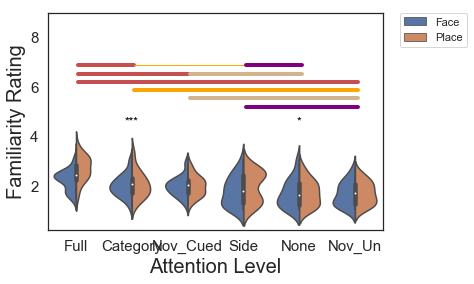

Experiment_2: Average Familiarity by Attention Level
Category

Full

None

Nov_Cued
independent ttest

Nov_Un
independent ttest

Side



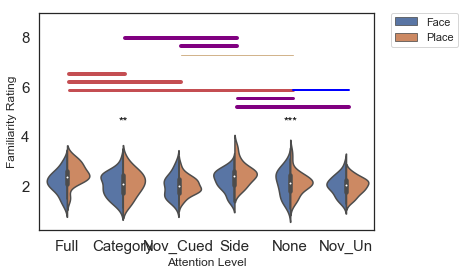

In [34]:
stat_dict_full = {'Experiment_1':{}, 'Experiment_2':{}}

# color list 
col = ['r','orange','tan','purple','blue','grey']
col_neg = ['grey','blue', 'purple', 'tan', 'orange', 'r']

# cat list
cats = ['Full','Category','Nov_Cued','Side','None','Nov_Un']

# plot settings
sb.set_style("white")
plt.grid(False)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.xlabel('Attention Level',    fontsize = 20)
plt.ylabel('Familiarity Rating', fontsize = 20)

# for each experiment, group and plot
for d,label in zip([exp1, exp2],['Experiment_1', 'Experiment_2']):
    
    data = d.groupby(['Subject','Attention Level', 'Category'], as_index = False).mean()
    print(label + ': Average Familiarity by Attention Level')
    sb_plot = sb.violinplot(x='Attention Level', y='Familiarity Rating', 
                 data = data, hue='Category', split=True,
                 order=cats)
    sb_plot.set(ylim=(.2, 9))
    ax1 = sb_plot.axes
    
    
    ### WITHIN VIOLIN SIGNIFICANCE FOR PLOTTING ###
    t_draw = {}
    
    for c in data['Attention Level'].unique():
        print(c)
        
        first  = list(data[(data['Attention Level']==c) & (data['Category']=='Face')]['Familiarity Rating'])
        second = list(data[(data['Attention Level']==c) & (data['Category']=='Place')]['Familiarity Rating'])
        
        if len(first)==len(second):
            t = scipy.stats.ttest_rel(first, second)
        else:
            print('independent ttest')
            t = scipy.stats.ttest_ind(first, second)  
        print()
        
        
        if t[1]<.001:
            t_draw[c] = '***'
            
        elif t[1]<.01:
            t_draw[c] = '**'
        
        elif t[1]<.05:
            t_draw[c] = '*'
            
        elif t[1]<.056:
            t_draw[c] = '+'
        
    
    
    ### SIGNIFICANCE FOR PLOTTING ###
    stat_dict = {}
    #stat_dict_full = {'Experiment_1':{}, 'Experiment_2':{}}
    k = data.groupby(['Subject','Attention Level'],as_index=False).mean()

    for pair in list(itertools.combinations(cats, r=2)):
        t = stats.ttest_rel(k[k['Attention Level']==pair[0]]['Familiarity Rating'], 
                            k[k['Attention Level']==pair[1]]['Familiarity Rating'])
        stat_dict_full[label][pair] = {'t': t.statistic, 'p': t.pvalue}

        # dictionary where every key is a pair of sig dif categories 
        if t[1]<.056:
            stat_dict[pair] = {'t': t.statistic, 'p': t.pvalue}
        
    ### ADD SIG BARS FOR POSITIVE RELATIONSHIPS TO PLOT ###
    plotted_cats = []
    to_be_plotted = []
    
    line_counter = 0
    
    for idx,c in enumerate(cats):
    # for each category
    
        x = sig_bars(c, cats, stat_dict)
        # get first series of lines
        
        for idx,a in enumerate(x):
            
            if (a['categories'] not in plotted_cats) and (a!=np.nan) and (type(a['categories'])!=float):
                a['y'] = a['y'] + line_counter
                to_be_plotted.append(a)
                plotted_cats.append(a['categories'])
                
                #print('first')
                #print(plotted_cats)
            
            if a['next']!=0:
            # if next category also has pos, significant relationship
            
                fake_first = a['categories'][0]
                b = a
                
                while b['next']!= 0 :
                    
                    second_fake_first = b['categories'][0]
                    
                    b = sig_bars(b['next'], cats, stat_dict, adjust = (cats.index(c)-cats.index(b['next']))/len(cats))[0]
                    # get params for that bar, adjust height --> same level as first line
                    if (b['categories'] not in plotted_cats) and (b != np.nan) and (type(b['categories'])!=float):
                        b['y'] = b['y'] + line_counter
                        to_be_plotted.append(b)
                            
                        plotted_cats.append(b['categories'])
                        plotted_cats.append((fake_first, b['categories'][1]))
                        plotted_cats.append((second_fake_first, b['categories'][1]))
                        
                        if type(plotted_cats[-1]) != float:
                            l = plotted_cats[-1][0]

                        plotted_cats.append((l,plotted_cats[-1][1]))
                        plotted_cats.append((fake_first,plotted_cats[-1][1]))
           
            line_counter += .3
                        
            if type(plotted_cats[-1]) == str:
                fake_last = plotted_cats[-1][1]
                plotted_cats.append((fake_first, fake_last))
    
    # get the unique y values
    y_vals = [x['y'] for x in to_be_plotted]
    unique = list(set(y_vals))
    unique.sort(reverse=True)

    # move each to desired location
    new_to_be_plotted = []

    for idx,u in enumerate(unique):
        for line in to_be_plotted:
            if line['y']==u:
                line['y'] = (idx/3)+5.2
                new_to_be_plotted.append(line)

    for each in new_to_be_plotted:
        ax1.axhline(each['y'], ls='-', xmin = each['x_min'], xmax = each['x_max'], 
            linewidth = each['width'], color = col[cats.index(each['categories'][0])])

    ### ADD SIG BARS FOR NEGATIVE RELATIONSHIPS TO PLOT ###
    plotted_cats = []
    to_be_plotted = []
    
    line_counter = 0
    
    for idx,c in enumerate(cats):
    # for each category 
    
        x = sig_bars_neg(c, cats, stat_dict)
        # get first series of lines
        
        for idx,a in enumerate(x):
            
            if (a['categories'] not in plotted_cats) and (a!=np.nan) and (type(a['categories'])!=float):
                a['y'] = a['y'] + line_counter
                to_be_plotted.append(a)
                plotted_cats.append(a['categories'])
            
            if a['next']!=0:
            # if next category also has pos, significant relationship
                
                fake_first = a['categories'][0]
                b = a
                
                while b['next']!= 0 :
                    
                    second_fake_first = b['categories'][0]
                    
                    b = sig_bars_neg(b['next'], cats, stat_dict, adjust = (cats.index(c)-cats.index(b['next']))/len(cats))[0]
                    # get params for that bar, adjust height --> same level as first line

                    if (b['categories'] not in plotted_cats) and (b != np.nan) and (type(b['categories'])!=float):
                        
                        b['y'] = b['y'] + line_counter
                        to_be_plotted.append(b)
                        
                        plotted_cats.append(b['categories'])
                        
                        plotted_cats.append((fake_first, b['categories'][1]))
                        plotted_cats.append((second_fake_first, b['categories'][1]))

                        if type(plotted_cats[-1]) != float:
                            l = plotted_cats[-1][0]
                                       
            line_counter += .3
            
                                    
            if len(plotted_cats)>0 and type(plotted_cats[-1]) == str:
                fake_last = plotted_cats[-1][1]
                plotted_cats.append((fake_first, fake_last))
    
    # get the unique y values
    y_vals = [x['y'] for x in to_be_plotted]
    unique = list(set(y_vals))
    unique.sort(reverse=True)

    # move each to desired location
    new_to_be_plotted = []

    for idx,u in enumerate(unique):
        for line in to_be_plotted:
            if line['y']==u:
                line['y'] = (idx/3)+7.3
                new_to_be_plotted.append(line)
                

    for each in new_to_be_plotted:
        ax1.axhline(each['y'], ls='-', xmin = each['x_min'], xmax = each['x_max'], 
            linewidth = each['width'], color = col[-cats.index(each['categories'][1])])
    for stars in t_draw:
        ax1.text((cats.index(stars)+1), 4.5, t_draw[stars], horizontalalignment='center', size='large', color='black')
        
        

    plt.savefig(label + "vio.pdf")    
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

In [35]:
# stat_dict_full = {'Experiment_1':{}, 'Experiment_2':{}}

# # color list 
# col = ['r','orange','tan','purple','blue','grey']
# col_neg = ['grey','blue', 'purple', 'tan', 'orange', 'r']

# # cat list
# cats = ['Full','Category','Nov_Cued','Side','None','Nov_Un']
# # cats = ['Full','Category','Side','None','Novel']

# # plot settings
# sb.set_style("white")
# plt.grid(False)
# plt.rc('xtick', labelsize=15)
# plt.rc('ytick', labelsize=15)
# plt.xlabel('Attention Level',    fontsize = 20)
# plt.ylabel('Familiarity Rating', fontsize = 20)

# # for each experiment, group and plot
# for d,label in zip([exp1, exp2],['Experiment_1', 'Experiment_2']):
    
#     data = d.groupby(['Subject','Attention Level', 'Category'], as_index = False).mean()
#     print(label + ': Average Familiarity by Attention Level')
#     sb_plot = sb.violinplot(x='Attention Level', y='Familiarity Rating', 
#                  data = data, hue='Category', split=True,
#                  order=cats)
#     sb_plot.set(ylim=(.2, 12))
#     ax1 = sb_plot.axes
    
    
#     ### WITHIN VIOLIN SIGNIFICANCE FOR PLOTTING ###
#     t_draw = {}
    
#     for c in data['Attention Level'].unique():
#         print(c)
        
#         first  = list(data[(data['Attention Level']==c) & (data['Category']=='Face')]['Familiarity Rating'])
#         second = list(data[(data['Attention Level']==c) & (data['Category']=='Place')]['Familiarity Rating'])
        
#         if len(first)==len(second):
#             t = scipy.stats.ttest_rel(first, second)
#         else:
#             print('independent ttest')
#             t = scipy.stats.ttest_ind(first, second)
#         #print(t)   
#         print()
        
        
#         if t[1]<.001:
#             t_draw[c] = '***'
            
#         elif t[1]<.01:
#             t_draw[c] = '**'
        
#         elif t[1]<.05:
#             t_draw[c] = '*'
            
#         elif t[1]<.056:
#             t_draw[c] = '+'
        
        
#     ### ACROSS VIOLIN SIGNIFICANCE FOR PLOTTING ###
#     #stat_dict = {}
#     stat_dict_full = {'Experiment_1':{}, 'Experiment_2':{}}
#     k = data.groupby(['Subject','Attention Level'],as_index=False).mean()

#     for pair in list(itertools.combinations(cats, r=2)):
#         t = stats.ttest_rel(k[k['Attention Level']==pair[0]]['Familiarity Rating'], 
#                             k[k['Attention Level']==pair[1]]['Familiarity Rating'])
#         stat_dict_full[label][pair] = {'t': t.statistic, 'p': t.pvalue}

        
#         #if 'Side' in pair:
#         print(pair)
#         print(t)
#         #print()
#         # dictionary where every key is a pair of sig dif categories 
#         if t[1]<.056:
#             stat_dict_full[label][pair] = {'t': t.statistic, 'p': t.pvalue}
        
#     ### ADD SIG BARS FOR POSITIVE RELATIONSHIPS TO PLOT ###
#     plotted_cats = []
#     to_be_plotted = []
    
#     line_counter = 0
    
#     for idx,c in enumerate(cats):
#     # for each category
    
#         x = sig_bars(c, cats, stat_dict_full[label])
#         # get first series of lines
        
#         for idx,a in enumerate(x):
            
#             if (a['categories'] not in plotted_cats) and (a!=np.nan) and (type(a['categories'])!=float):
# #                 listy = [ (a['categories'][0],cats[x]) for x in range(cats.index(a['categories'][0])+1, cats.index(a['categories'][1]))]
# #                 if not set(listy).intersection(set(plotted_cats)):

#                 a['y'] = a['y'] + line_counter
#                 to_be_plotted.append(a)
#                 plotted_cats.append(a['categories'])
            
#             if a['next']!=0:
#             # if next category also has pos, significant relationship
            
#                 fake_first = a['categories'][0]
#                 b = a
                
#                 while b['next']!= 0 :
                    
#                     second_fake_first = b['categories'][0]
                    
#                     b = sig_bars(b['next'], cats, stat_dict_full, adjust = (cats.index(c)-cats.index(b['next']))/len(cats))[0]
#                     # get params for that bar, adjust height --> same level as first line
#                     if (b['categories'] not in plotted_cats) and (b != np.nan) and (type(b['categories'])!=float):
#                         b['y'] = b['y'] + line_counter
#                         to_be_plotted.append(b)
                            
#                         plotted_cats.append(b['categories'])
                        
#                         plotted_cats.append((fake_first, b['categories'][1]))
#                         plotted_cats.append((second_fake_first, b['categories'][1]))

#                         if type(plotted_cats[-1]) != float:
#                             l = plotted_cats[-1][0]

# #                         plotted_cats.append((l,plotted_cats[-1][1]))
                        
# #                         print('fourth')
# #                         print(plotted_cats)
                        
# #                         plotted_cats.append((fake_first,plotted_cats[-1][1]))
                        
# #                         print('fifth')
# #                         print(plotted_cats)
           
#             #line_counter += .3
                        
#             if type(plotted_cats[-1]) == str:
                
#                 fake_last = plotted_cats[-1][1]
#                 plotted_cats.append((fake_first, fake_last))
    
#     # get the unique y values
#     y_vals = [x['y'] for x in to_be_plotted]
#     unique = list(set(y_vals))
#     unique.sort(reverse=True)
    
    
#     # move each to desired location
#     new_to_be_plotted = []

#     for idx,u in enumerate(unique):
#         for line in to_be_plotted:
#             if line['y']==u:
#                 line['y'] = (idx/3)+7.3
#                 new_to_be_plotted.append(line)

#     for each in new_to_be_plotted:
#         ax1.axhline(each['y'], ls='-', xmin = each['x_min'], xmax = each['x_max'], 
#             linewidth = each['width'], color = col[-cats.index(each['categories'][0])])
    
    
    

# #     # move each to desired location
# #     new_to_be_plotted = []

# #     for idx,u in enumerate(unique):
# #         for line in to_be_plotted:
# #             if line['y']==u:
# #                 line['y'] = (idx/3)+5.2
# #                 new_to_be_plotted.append(line)

# #     for each in new_to_be_plotted:
# #         ax1.axhline(each['y'], ls='-', xmin = each['x_min'], xmax = each['x_max'], 
# #             linewidth = each['width'], color = col[cats.index(each['categories'][0])])

#     ### ADD SIG BARS FOR NEGATIVE RELATIONSHIPS TO PLOT ###
#     plotted_cats = []
#     to_be_plotted = []
    
#     line_counter = 0
    
#     for idx,c in enumerate(cats):
#     # for each category 
    
#         x = sig_bars_neg(c, cats, stat_dict_full)
#         # get first series of lines
        
#         for idx,a in enumerate(x):
            
#             if (a['categories'] not in plotted_cats) and (a!=np.nan) and (type(a['categories'])!=float):
#                 a['y'] = a['y'] + line_counter
#                 to_be_plotted.append(a)
#                 plotted_cats.append(a['categories'])
            
#             if a['next']!=0:
#             # if next category also has pos, significant relationship

#                 b = a
#                 while b['next']!= 0 :

#                     second_fake_first = b['categories'][0]

#                     b = sig_bars_neg(b['next'], cats, stat_dict, adjust = (cats.index(c)-cats.index(b['next']))/len(cats))[0]
#                     # get params for that bar, adjust height --> same level as first line

#                     if (b['categories'] not in plotted_cats) and (b != np.nan) and (type(b['categories'])!=float):

#                         b['y'] = b['y'] + line_counter
#                         to_be_plotted.append(b)

#                         plotted_cats.append(b['categories'])

#                         plotted_cats.append((fake_first, b['categories'][1]))
#                         plotted_cats.append((second_fake_first, b['categories'][1]))

#                         if type(plotted_cats[-1]) != float:
#                             l = plotted_cats[-1][0]
                
# #                 while b['next']!= 0 :
                    
# #                     b = sig_bars_neg(b['next'], cats, stat_dict_full, adjust = (cats.index(c)-cats.index(b['next']))/len(cats))[0]
# #                     # get params for that bar, adjust height --> same level as first line

# #                     if (b['categories'] not in plotted_cats) and (b != np.nan) and (type(b['categories'])!=float):
                        
# #                         b['y'] = b['y'] + line_counter
# #                         to_be_plotted.append(b)
                                       
#                         #line_counter += .3
    
#     # get the unique y values
#     y_vals = [x['y'] for x in to_be_plotted]
#     unique = list(set(y_vals))
#     unique.sort(reverse=True)

    
    
#     # move each to desired location
#     new_to_be_plotted = []

#     for idx,u in enumerate(unique):
#         for line in to_be_plotted:
#             if line['y']==u:
#                 line['y'] = (idx/3)+7.3
#                 new_to_be_plotted.append(line)

#     for each in new_to_be_plotted:
#         ax1.axhline(each['y'], ls='-', xmin = each['x_min'], xmax = each['x_max'], 
#             linewidth = each['width'], color = col[-cats.index(each['categories'][0])])
    
    
# #     # move each to desired location
# #     new_to_be_plotted = []

# #     for idx,u in enumerate(unique):
# #         for line in to_be_plotted:
# #             if line['y']==u:
# #                 line['y'] = (idx/3)+7.3
# #                 new_to_be_plotted.append(line)

# #     for each in new_to_be_plotted:
# #         ax1.axhline(each['y'], ls='-', xmin = each['x_min'], xmax = each['x_max'], 
# #             linewidth = each['width'], color = col[cats.index(each['categories'][0])])

        
#     for stars in t_draw:
#         ax1.text((cats.index(stars)+1), 4.5, t_draw[stars], horizontalalignment='center', size='large', color='black')
        
        
#     plt.savefig(label + "vio.pdf")    
    
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.show()      

## FIRST AND LAST TRIAL CHUNKS

Experiment_1_first_10: Average Familiarity by Attention Level
Category

Full

None

Nov_Cued

Nov_Un

Side



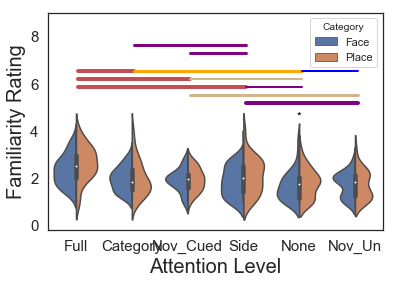

Experiment_2_first_10: Average Familiarity by Attention Level
Category
independent ttest

Full

None
independent ttest

Nov_Cued
independent ttest

Nov_Un
independent ttest

Side
independent ttest



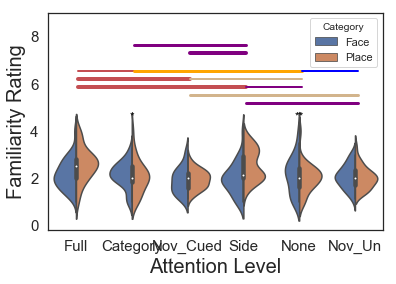

In [51]:
import itertools
from scipy import stats

for d,label in zip([exp1, exp2],['Experiment_1_first_10', 'Experiment_2_first_10']):
    
    d = d[d['Trial']<10]
    data = d.groupby(['Subject','Attention Level','Category'], as_index = False).mean()
    
    
    print(label + ': Average Familiarity by Attention Level')
    
    plt.grid(False)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xlabel('Attention Level',    fontsize = 20)
    plt.ylabel('Familiarity Rating', fontsize = 20)
    
    ax1 = sb.violinplot(x='Attention Level', y='Familiarity Rating', 
                 data = data,
                 order=['Full','Category','Nov_Cued','Side','None','Nov_Un'],
                           hue='Category', split=True)
    
    
    
    # INSERT #
    
    
       
    ### WITHIN VIOLIN SIGNIFICANCE FOR PLOTTING ###
    t_draw = {}
    
    for c in data['Attention Level'].unique():
        print(c)
        
        first  = list(data[(data['Attention Level']==c) & (data['Category']=='Face')]['Familiarity Rating'])
        second = list(data[(data['Attention Level']==c) & (data['Category']=='Place')]['Familiarity Rating'])
        
        if len(first)==len(second):
            t = scipy.stats.ttest_rel(first, second)
        else:
            print('independent ttest')
            t = scipy.stats.ttest_ind(first, second)  
        print()
        
        
        if t[1]<.001:
            t_draw[c] = '***'
            
        elif t[1]<.01:
            t_draw[c] = '**'
        
        elif t[1]<.05:
            t_draw[c] = '*'
            
        elif t[1]<.056:
            t_draw[c] = '+'
        
    
    ### SIGNIFICANCE FOR PLOTTING ###
    #stat_dict = {}
    stat_dict_full = {'Experiment_1_first_10':{}, 'Experiment_2_first_10':{}}
    k = data.groupby(['Subject','Attention Level'],as_index=False).mean()

    for pair in list(itertools.combinations(cats, r=2)):
        t = stats.ttest_rel(k[k['Attention Level']==pair[0]]['Familiarity Rating'], 
                            k[k['Attention Level']==pair[1]]['Familiarity Rating'])
        stat_dict_full[label][pair] = {'t': t.statistic, 'p': t.pvalue}

        # dictionary where every key is a pair of sig dif categories 
        if t[1]<.056:
            stat_dict[pair] = {'t': t.statistic, 'p': t.pvalue}
        
    ### ADD SIG BARS FOR POSITIVE RELATIONSHIPS TO PLOT ###
    plotted_cats = []
    to_be_plotted = []
    
    line_counter = 0
    
    for idx,c in enumerate(cats):
    # for each category
    
        x = sig_bars(c, cats, stat_dict)
        # get first series of lines
        
        for idx,a in enumerate(x):
            
            if (a['categories'] not in plotted_cats) and (a!=np.nan) and (type(a['categories'])!=float):
                a['y'] = a['y'] + line_counter
                to_be_plotted.append(a)
                plotted_cats.append(a['categories'])
                
                #print('first')
                #print(plotted_cats)
            
            if a['next']!=0:
            # if next category also has pos, significant relationship
            
                fake_first = a['categories'][0]
                b = a
                
                while b['next']!= 0 :
                    
                    second_fake_first = b['categories'][0]
                    
                    b = sig_bars(b['next'], cats, stat_dict, adjust = (cats.index(c)-cats.index(b['next']))/len(cats))[0]
                    # get params for that bar, adjust height --> same level as first line
                    if (b['categories'] not in plotted_cats) and (b != np.nan) and (type(b['categories'])!=float):
                        b['y'] = b['y'] + line_counter
                        to_be_plotted.append(b)
                            
                        plotted_cats.append(b['categories'])
                        plotted_cats.append((fake_first, b['categories'][1]))
                        plotted_cats.append((second_fake_first, b['categories'][1]))
                        
                        if type(plotted_cats[-1]) != float:
                            l = plotted_cats[-1][0]

                        plotted_cats.append((l,plotted_cats[-1][1]))
                        plotted_cats.append((fake_first,plotted_cats[-1][1]))
           
            line_counter += .3
                        
            if type(plotted_cats[-1]) == str:
                fake_last = plotted_cats[-1][1]
                plotted_cats.append((fake_first, fake_last))
    
    # get the unique y values
    y_vals = [x['y'] for x in to_be_plotted]
    unique = list(set(y_vals))
    unique.sort(reverse=True)

    # move each to desired location
    new_to_be_plotted = []

    for idx,u in enumerate(unique):
        for line in to_be_plotted:
            if line['y']==u:
                line['y'] = (idx/3)+5.2
                new_to_be_plotted.append(line)

    for each in new_to_be_plotted:
        ax1.axhline(each['y'], ls='-', xmin = each['x_min'], xmax = each['x_max'], 
            linewidth = each['width'], color = col[cats.index(each['categories'][0])])

    ### ADD SIG BARS FOR NEGATIVE RELATIONSHIPS TO PLOT ###
    plotted_cats = []
    to_be_plotted = []
    
    line_counter = 0
    
    for idx,c in enumerate(cats):
    # for each category 
    
        x = sig_bars_neg(c, cats, stat_dict)
        # get first series of lines
        
        for idx,a in enumerate(x):
            
            if (a['categories'] not in plotted_cats) and (a!=np.nan) and (type(a['categories'])!=float):
                a['y'] = a['y'] + line_counter
                to_be_plotted.append(a)
                plotted_cats.append(a['categories'])
            
            if a['next']!=0:
            # if next category also has pos, significant relationship
                
                fake_first = a['categories'][0]
                b = a
                
                while b['next']!= 0 :
                    
                    second_fake_first = b['categories'][0]
                    
                    b = sig_bars_neg(b['next'], cats, stat_dict, adjust = (cats.index(c)-cats.index(b['next']))/len(cats))[0]
                    # get params for that bar, adjust height --> same level as first line

                    if (b['categories'] not in plotted_cats) and (b != np.nan) and (type(b['categories'])!=float):
                        
                        b['y'] = b['y'] + line_counter
                        to_be_plotted.append(b)
                        
                        plotted_cats.append(b['categories'])
                        
                        plotted_cats.append((fake_first, b['categories'][1]))
                        plotted_cats.append((second_fake_first, b['categories'][1]))

                        if type(plotted_cats[-1]) != float:
                            l = plotted_cats[-1][0]
                                       
            line_counter += .3
                                 
            if len(plotted_cats)>0 and type(plotted_cats[-1]) == str:
                fake_last = plotted_cats[-1][1]
                plotted_cats.append((fake_first, fake_last))
    
    # get the unique y values
    y_vals = [x['y'] for x in to_be_plotted]
    unique = list(set(y_vals))
    unique.sort(reverse=True)

    # move each to desired location
    new_to_be_plotted = []

    for idx,u in enumerate(unique):
        for line in to_be_plotted:
            if line['y']==u:
                line['y'] = (idx/3)+7.3
                new_to_be_plotted.append(line)
                
    for each in new_to_be_plotted:
        ax1.axhline(each['y'], ls='-', xmin = each['x_min'], xmax = each['x_max'], 
            linewidth = each['width'], color = col[-cats.index(each['categories'][1])])
    for stars in t_draw:
        ax1.text((cats.index(stars)+1), 4.5, t_draw[stars], horizontalalignment='center', size='large', color='black')
        
        
    # INSERT #
    
    save_string = label + '_NEWviolin.pdf'
    
    ax1.set(ylim=(-.2, 9))
    
    plt.savefig(save_string)
    
    plt.show()
    
    
    

#     print(pingouin.rm_anova(dv='Familiarity Rating', within=['Attention Level'], subject='Subject', 
#                   data=d.groupby(['Subject','Attention Level'],as_index=False).mean()))
#     print()
    
#     l=['Category','None','Side','Full','Nov_Cued','Nov_Un']
#     k=data.groupby(['Subject','Attention Level'],as_index=False).mean()

#     for pair in list(itertools.combinations(l, r=2)):
#         t = stats.ttest_rel(k[k['Attention Level']==pair[0]]['Familiarity Rating'], 
#                             k[k['Attention Level']==pair[1]]['Familiarity Rating'])

#         print(pair[0]+" vs. "+pair[1])
#         print(t) 
#         print()

In [ ]:
col = ['r','m','c','y','g','b']

# Heatmaps

In [29]:
index = ['Full', 'Category', 'Nov_Cued', 'Side', 'None', 'Nov_Un']
columns = index
df_t = pd.DataFrame(index=index, columns=columns)
df_t = df_t.fillna(1) # with 0s rather than NaNs
df_p = df_t.fillna(1)

In [30]:
color = sb.diverging_palette(240, 10, n=9, as_cmap=True) 

Experiment_1, p-vals


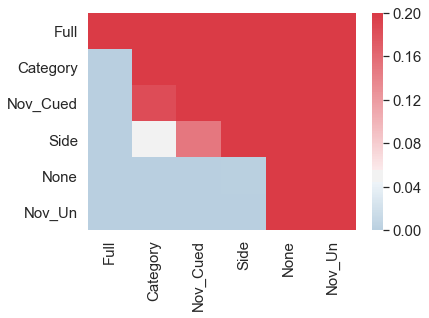

Experiment_1, t-vals


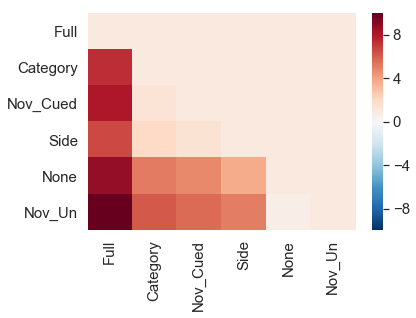

Experiment_2, p-vals


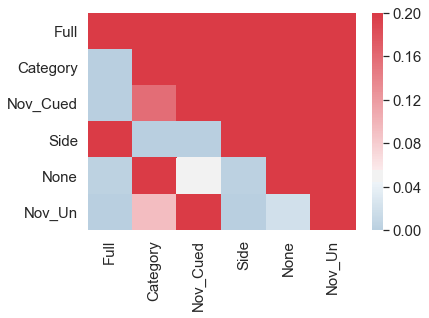

Experiment_2, t-vals


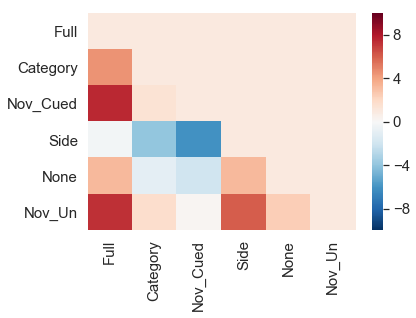

In [31]:
for data in stat_dict_full:
    
    df = pd.DataFrame(stat_dict_full[data])
    df.reset_index(level=0, inplace=True)
    
    for idx,x in enumerate(index):
        if x!='Nov_Un':
            df_p[x].loc[index[(idx+1):]] = list(df[x].loc[0])
        if x!='Nov_Un':
            df_t[x].loc[index[(idx+1):]] = list(df[x].loc[1])
    print(data+', p-vals')
    sb.heatmap(df_p, vmin=0,vmax=.2,center=.05,cmap=color)
    #, cmap = color)
    plt.show()
    print(data+', t-vals')
    sb.heatmap(df_t, vmin=-10,vmax=10,center=0,cmap="RdBu_r")
    #sb.heatmap(df_t, cmap = color)
    plt.show()

### Raw Mean Familiarity Over Time - All Images

Experiment 1: Average Familiarity Over Time (Raw Data)


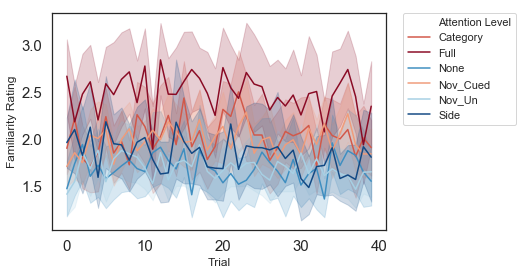

Experiment 2: Average Familiarity Over Time (Raw Data)


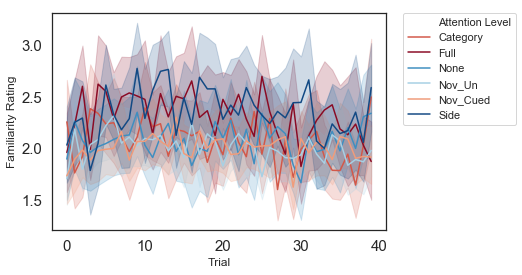

In [32]:
for data,label in zip([exp1, exp2],['Experiment 1','Experiment 2']): #plot_data.keys():
    
    print(label + ': Average Familiarity Over Time (Raw Data)')

    ax = sb.lineplot(x='Trial',y='Familiarity Rating', hue = 'Attention Level', 
                data = data.groupby(['Subject','Trial','Attention Level'], as_index=False).mean(), # ci=None,
                palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13]})
        
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    ax.set(ylim=(1.5, 3))

### Raw Mean Familiarity for Novel Images Over Time

Experiment 1: Average Familiarity for Novel Images Over Time (Raw Data)


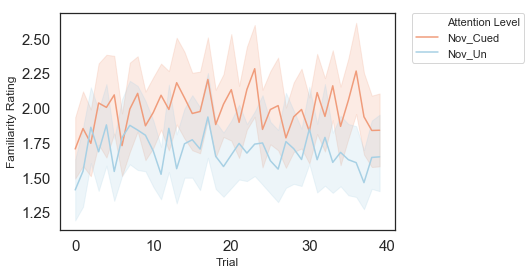

Experiment 2: Average Familiarity for Novel Images Over Time (Raw Data)


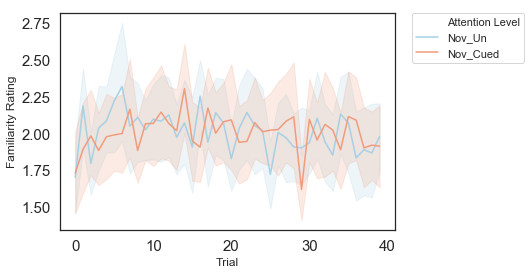

In [33]:
for data,label in zip([exp1, exp2],['Experiment 1','Experiment 2']): #plot_data.keys():
    
    print(label + ': Average Familiarity for Novel Images Over Time (Raw Data)')

    ax = sb.lineplot(x='Trial',y='Familiarity Rating', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Nov_Un','Nov_Cued'])].groupby(['Subject','Trial','Attention Level'], as_index=False).mean(), # ci=None,
                           palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13]})

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    ax.set(ylim=(1.5, 3))

### Sliding Window - Familiarity Over Time

ANOVA --> significant effect of attention level on familiarity both in the first and last window-sized chunks of "time," for both experiments.

*note : t-test breakdown for early vs late windows in later cells


exp1: Sliding Window - Familiarity Over Time


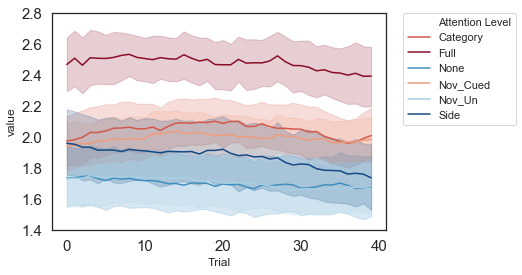

exp2: Sliding Window - Familiarity Over Time


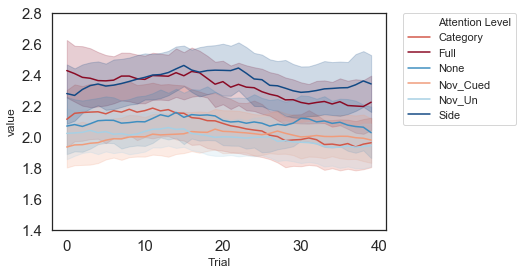

In [34]:
for key in plot_data.keys():
    
    print(key + ': Sliding Window - Familiarity Over Time')
    
    data = plot_data[key]
    
    # make a lineplot
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data.groupby(['Subject','Trial','Attention Level'], as_index=False).mean(),
                  palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13]}) 
                #, colors = ['green', 'blue', 'grey', 'red','orange','yellow'])
    
    # show plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylim=(1.4, 2.8))
    plt.show()
    

### Sliding Window - Novel Images

Exp 2: Novel Images that are not in the last-cued category have significantly higher familiarity ratings at the beginning of the memory block (first window) than they do at the end of the memory block (last window).

exp1: Sliding Window - Novel Images Only
[True]


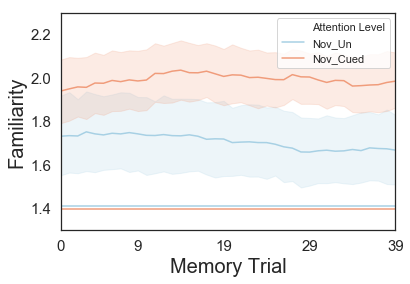

exp2: Sliding Window - Novel Images Only
[False]


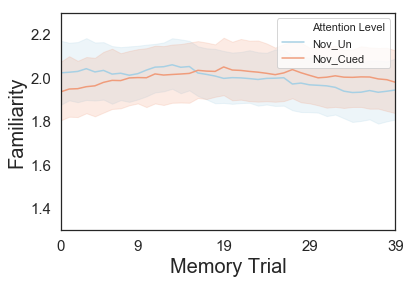

In [54]:
import scipy

sb.set_style("white")

for key,label in zip(plot_data.keys(),['Experiment_1','Experiment_2']):
    
    print(key + ': Sliding Window - Novel Images Only')
    
    data = plot_data[key]
    
    # plot data
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Nov_Un','Nov_Cued'])], # ci=None,
                palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13]})
    ax.set(ylim=(1.3, 2.3))
    ax.set(xlim=(0, 39))
    
    plt.grid(False)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xlabel('Attention Level',    fontsize = 20)
    plt.ylabel('Familiarity Rating', fontsize = 20)
    
    plt.xlabel('Memory Trial')
    plt.ylabel('Familiarity')
    
    # ttest at each timepoint ######################
    ttest_data = timepoint_ttest(data, ['Nov_Cued','Nov_Un'])
    print(ttest_data[ttest_data['Attention Level'].isin(['Nov_Un'])]['timepoint_t_truth'].unique())
    
    # add gret lines where pvalue is significant
    index = ttest_data[(ttest_data['Attention Level']=='Nov_Un') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    for x in ranges(index):
        #print(x)
        
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.41, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[13])
            plt.axhline( y=1.4, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[5])
        
        plt.axhline( y=1.41, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[13])
        plt.axhline( y=1.4, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[5])
        # plt.axvline(x, .1, .3, color='red')
    
    plt.xticks([0, 9, 19, 29, 39])
    plt.savefig('Novel_tcourse_'+label+'.pdf')
    plt.show()    
    

In [36]:
# plot_data[key][plot_data[key]['Attention Level']=='Nov_Un']

### Novel Image Difference Scores

exp1


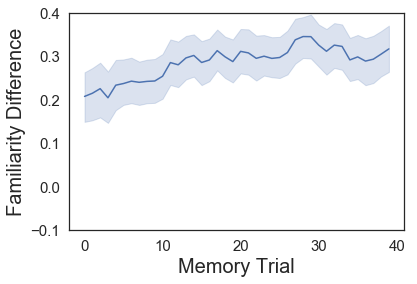

exp2


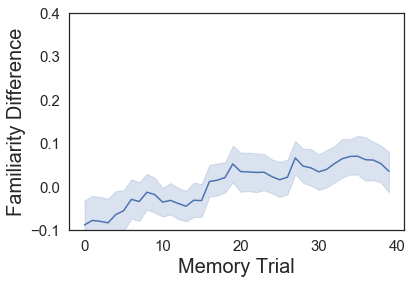

In [37]:
for exp in plot_data.keys():
    
    trial_avs = plot_data[exp].groupby(['Trial','Attention Level','Subject'], as_index=False).mean()
    trial_avs['Nov_Diffs'] = np.nan
    
    for s in trial_avs['Subject'].unique():
        for t in trial_avs['Trial'].unique():

            first  = trial_avs[(trial_avs['Attention Level']=='Nov_Cued') 
                               & (trial_avs['Trial']==t)
                              & (trial_avs['Subject']==s)]['value'].item()
            second = trial_avs[(trial_avs['Attention Level']=='Nov_Un'  ) 
                               & (trial_avs['Trial']==t)
                              & (trial_avs['Subject']==s)]['value'].item()
            difference = first - second
            #print(difference)
            trial_avs.loc[(trial_avs['Trial']==t) & (trial_avs['Subject']==s),'Nov_Diffs'] = first - second

    ax = sb.lineplot(x='Trial', y='Nov_Diffs', data=trial_avs)
    ax.set(ylim=(-.1, .4))
        
    plt.grid(False)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xlabel('Attention Level',    fontsize = 20)
    plt.ylabel('Familiarity Rating', fontsize = 20)
    
    plt.xlabel('Memory Trial')
    plt.ylabel('Familiarity Difference')
    plt.savefig('Novel_Diff_'+ exp +'.pdf')
    print(exp)
    plt.show()


### Sliding window with bars - add grey

Experiment 1: Sliding Window - Novel Images Only


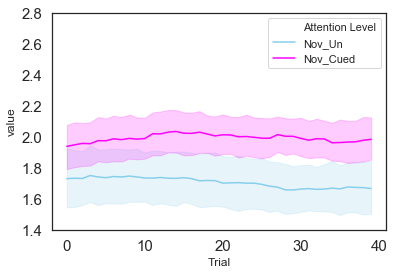

[True]


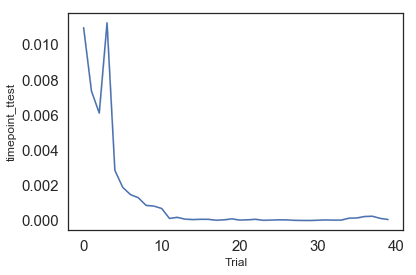

t-test, first window versus last window: Nov_Un
Ttest_relResult(statistic=1.072311225543634, pvalue=0.2924230422504016)


t-test, first window versus last window: Nov_Cued
Ttest_relResult(statistic=-0.7130830216781135, pvalue=0.4814935405610479)


Experiment 2: Sliding Window - Novel Images Only


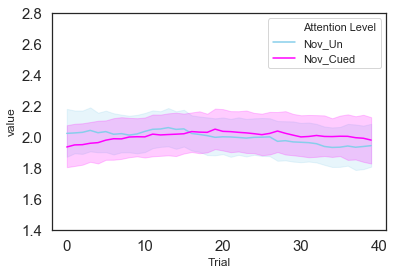

[False]


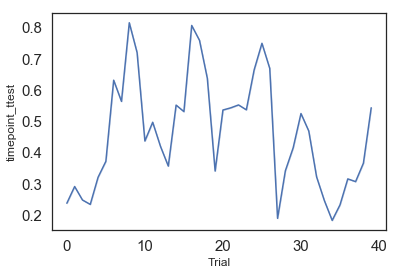

t-test, first window versus last window: Nov_Un
Ttest_relResult(statistic=1.2687477463130798, pvalue=0.2146208296963119)


t-test, first window versus last window: Nov_Cued
Ttest_relResult(statistic=-0.5693976457391752, pvalue=0.5734707138585988)




In [38]:
sb.set_style("white")


for key,label in zip(plot_data.keys(),['Experiment 1','Experiment 2']):
    
    print(label + ': Sliding Window - Novel Images Only')
    
    data = plot_data[key]
    
    # plot data
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Nov_Un','Nov_Cued'])], # ci=None,
                    palette = {"Full": "crimson", "Category": "deeppink", "Nov_Cued":"magenta", 
                           "Side": "blue", "None": "dodgerblue", "Nov_Un":"skyblue"})
    ax.set(ylim=(1.4, 2.8))
    plt.show()
    
    # ttest at each timepoint
    ttest_data = timepoint_ttest(data, ['Nov_Cued','Nov_Un'])
    print(ttest_data[ttest_data['Attention Level'].isin(['Nov_Un','Nov_Cued'])]['timepoint_t_truth'].unique())
    ax = sb.lineplot(x='Trial', y='timepoint_ttest', data=ttest_data[ttest_data['Attention Level']=='Nov_Cued'])
    # ax.set(ylim=(-.7,1))
    plt.show()
    
    ttest_data['abs_tval'] = ttest_data['timepoint_tvalue'].abs()
    
    
        # ttest first versus last window
    for cat in ['Nov_Un', 'Nov_Cued']:

        dat = data[data['Attention Level']==cat]
        
        first_window = dat[dat['Trial']<1].groupby(['Attention Level','Subject'], as_index=False).mean()
        last_window  = dat[dat['Trial']>38].groupby(['Attention Level','Subject'], as_index=False).mean()

        t = scipy.stats.ttest_rel(list(first_window['value']), list(last_window['value']))
    
        # t = scipy.stats.ttest_ind(list(first_window['value']), list(last_window['value']))

        print('t-test, first window versus last window: '+cat)
        print(t)
        print()
        print()
    
#     ax = sb.lineplot(x='Trial', y='timepoint_t_truth', data=ttest_data[ttest_data['Attention Level']=='Nov_Cued'])
#     ax.set(ylim=(-2, 6.5))
#     ax = sb.regplot(x='Trial', y='time', data=ttest_data[ttest_data['Attention Level']=='Nov_Cued'])
    
    
#     plt.grid(False)
#     plt.rc('xtick', labelsize=15)
#     plt.rc('ytick', labelsize=15)
#     plt.xlabel('Memory Trial',    fontsize = 20)
#     plt.ylabel('| t-statistic |', fontsize = 20)
    
#     plt.savefig('tcourse_t_regress_'+label+'.pdf')
#     plt.show()

In [39]:
# --> regression line on t stat over time

# --> familiarity for presented images (attn levels) as a function of their position on the presentation list
# --> for both exps (rec memory spc)
#     --> compare first to middle to end
#     --> primacy and recency
    
    
# # FUTURE
# #
# # temp clustering
# #  
# #
# #


### Sliding Window - Images in Uncued Category

In experiment 1, the images in the uncued category start with significiantly different familiarity ratings (first window), but byt hte end of the run, have familiarity ratings that are not significantly different (last window).

Experiment 2 is the opposite:  the images in the uncued category start not significiantly different from each other (first window), but by the end of the run, they have familiarity ratings that are significantly different (last window).

In experiment 1: "Side" images are significantly more familiar at the start of a run than at the end of a run.

In experiment 2: Novel imgaes from the last-uncued category are rated significantly more familiar in the first window than in the last window.

Experiment_1: Sliding Window - Uncued Category Images
[True]


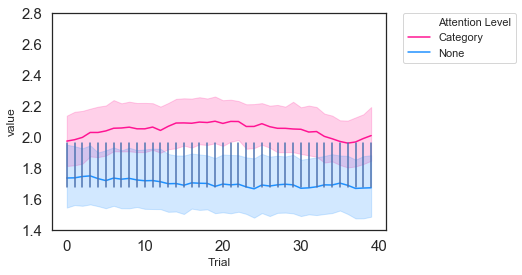

T-TESTS :

t-test, first window versus last window: Nov_Un
Ttest_relResult(statistic=1.5776156564805914, pvalue=0.1255013096610064)


t-test, first window versus last window: Side
Ttest_relResult(statistic=3.084938539950933, pvalue=0.004443924165601571)


t-test, first window versus last window: None
Ttest_relResult(statistic=0.776816648377768, pvalue=0.44355748161391384)




Experiment_2: Sliding Window - Uncued Category Images
[False True]


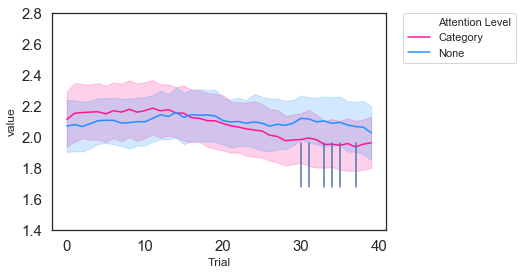

T-TESTS :

t-test, first window versus last window: Nov_Un
Ttest_relResult(statistic=2.894710676339515, pvalue=0.00713869333650597)


t-test, first window versus last window: Side
Ttest_relResult(statistic=0.9279562268094116, pvalue=0.36108983540537354)


t-test, first window versus last window: None
Ttest_relResult(statistic=0.4590538104235845, pvalue=0.6496178839668159)






In [40]:
for key,label in zip(plot_data.keys(),['Experiment_1','Experiment_2']):
    
    print(label + ': Sliding Window - Uncued Category Images')
    
    data = plot_data[key]
    
    # plot data ##################################
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Category','None'])], # ci=None,
                    palette = {"Full": "crimson", "Category": "deeppink", "Nov_Cued":"magenta", 
                           "Side": "blue", "Novel":"black", "None": "dodgerblue", "Nov_Un":"skyblue"})
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylim=(1.4, 2.8))
    
    
    # ttest at each timepoint ######################
    ttest_data = timepoint_ttest(data, ['Category','None'])
    print(ttest_data[ttest_data['Attention Level'].isin(['Category','None'])]['timepoint_t_truth'].unique())
    
    # add gret lines where pvalue is significant
    index = ttest_data[(ttest_data['Attention Level']=='Category') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    for x in index:
        plt.axvline(x, .2, .4)
        
    plt.savefig('Cat_None_'+label+'.pdf')
    plt.show()
    #################################################
    
    # ttest first versus last window
    
    print('T-TESTS :')
    print()
    
    for cat in ['Nov_Un', 'Side', 'None']:

        d = data[data['Attention Level']==cat]
        
        # single first and last window
        first_window = d[d['Trial']==0].groupby(['Attention Level','Subject'], as_index=False).mean()
        first_window = d[d['Trial']==39].groupby(['Attention Level','Subject'], as_index=False).mean()
        
        first_window = d[d['Trial']<(window_length*2)-1].groupby(['Attention Level','Subject'], as_index=False).mean()
        last_window  = d[d['Trial']>29].groupby(['Attention Level','Subject'], as_index=False).mean()

        t = scipy.stats.ttest_rel(list(first_window['value']), list(last_window['value']))
    
        # t = scipy.stats.ttest_ind(list(first_window['value']), list(last_window['value']))

        print('t-test, first window versus last window: '+cat)
        print(t)
        print()
        print()


    print()
    print()

In [41]:
def ranges(nums):
    nums = sorted(set(nums))
    gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s+1 < e]
    edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
    return list(zip(edges, edges))

ranges(index)

[(30.0, 31.0), (33.0, 35.0), (37.0, 37.0)]

In [42]:
#data[data['Attention Level']=='Side']

# Same w/ timepoint ttest

Experiment 1: Sliding Window - Uncued Category Images
[True False]
(0.0, 35.0)
[True False]
(0.0, 2.0)
(5.0, 31.0)


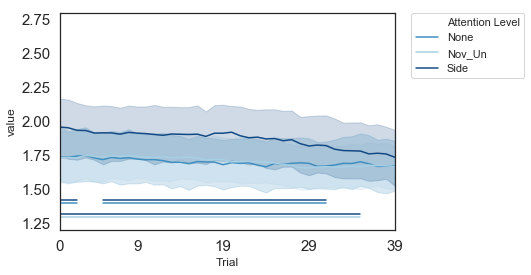

Experiment 2: Sliding Window - Uncued Category Images
[True]
(0.0, 39.0)
[False True]
(2.0, 39.0)
(16.0, 22.0)
(30.0, 37.0)


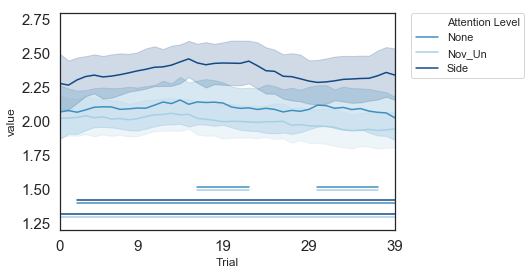

In [43]:
from itertools import groupby
from operator import itemgetter


sb.set_style("white")

for key,label in zip(plot_data.keys(),['Experiment 1','Experiment 2']):
    
    print(label + ': Sliding Window - Uncued Category Images')
    
    data = plot_data[key]
    
    # plot data
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Side','None','Nov_Un'])], # ci=None,
                    palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13], 'Novel':'black'}) 
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylim=(1.2, 2.8))
    ax.set(xlim=(0, 39))

    
    # stats test
    data = data[data['Attention Level'].isin(['Side','None','Nov_Un'])]
    
    #ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Side','Nov_Un'])#, related=False)
    print(ttest_data[ttest_data['Attention Level']=='Side']['timepoint_t_truth'].unique())
    
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Nov_Un') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    
    for x in ranges(index):
        print(x)
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.32, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[19])
            plt.axhline( y=1.3, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[13])
                        
        else:
            plt.axhline( y=1.32, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[19])
            plt.axhline( y=1.3, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[13])
        
        
    # ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Side','None'])
    print(ttest_data[ttest_data['Attention Level']=='None']['timepoint_t_truth'].unique())
    
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Side') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    for x in ranges(index):
        print(x)
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.42, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[19])
            plt.axhline( y=1.4, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[16])
            
        else:
            plt.axhline( y=1.42, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[19])
            plt.axhline( y=1.4, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[16])
        
    # ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Nov_Un','None'])#, related=False)
    #print(ttest_data[ttest_data['Attention Level']=='Category']['timepoint_t_truth'].unique())
    
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Nov_Un') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    for x in ranges(index):
        print(x)
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.52, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[16])
            plt.axhline( y=1.5, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[13])
    
        else:
            plt.axhline( y=1.52, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[16])
            plt.axhline( y=1.5, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[13])
    
#     # ttest at each timepoint ######################
#     ttest_data = timepoint_ttest(data, ['Novel','None'])
#     #print(ttest_data[ttest_data['Attention Level'].isin(['None','Novel'])]['timepoint_t_truth'].unique())
    
#     # add gret lines where pvalue is significant
#     index = ttest_data[(ttest_data['Attention Level']=='None') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
#     index = set(index)
    
#     for x in index:
#         plt.axhline( y=1.45, xmin=x, xmax=x+1, color='dodgerblue')
#         plt.axhline( y=1.43, xmin=x, xmax=x+1, color='black')
#         # plt.axvline(x, .1, .3, color='red')
    
#     # ttest at each timepoint ######################
#     ttest_data = timepoint_ttest(data, ['Novel','Side'])
#     #print(ttest_data[ttest_data['Attention Level'].isin(['Side','Novel'])]['timepoint_t_truth'])
    
#     # add gret lines where pvalue is significant
#     index = ttest_data[(ttest_data['Attention Level']=='Side') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
#     index = set(index)
    
#     for x in index:
#         plt.axhline( y=1.5, xmin=x, xmax=x+1, color='blue')
#         plt.axhline( y=1.48, xmin=x, xmax=x+1, color='black')
#         # plt.axvline(x, .1, .3, color='red')
        
#     # ttest at each timepoint ######################
#     ttest_data = timepoint_ttest(data, ['None','Side'])
#     #print(ttest_data[ttest_data['Attention Level'].isin(['Side','None'])]['timepoint_t_truth'].unique())
    
#     # add gret lines where pvalue is significant
#     index = ttest_data[(ttest_data['Attention Level']=='None') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
#     index = set(index)
    
#     for x in index:
#         plt.axhline( y=1.55, xmin=x, xmax=x+1, color='blue')
#         plt.axhline( y=1.53, xmin=x, xmax=x+1, color='dodgerblue')
        
        # plt.axvline(x, .1, .3, color='red')
        
    plt.xticks([0, 9, 19, 29, 39])
    plt.savefig(label+'_UncuedCategory.pdf')
    plt.show()
    
    
#     first_window = data[data['Trial']<1].groupby(['Attention Level','Subject'], as_index=False).mean()
#     last_window  = data[data['Trial']>38].groupby(['Attention Level','Subject'], as_index=False).mean()
#     anova = pingouin.rm_anova(dv='value', within='Attention Level', subject='Subject', data=first_window)
#     anova_last = pingouin.rm_anova(dv='value', within='Attention Level', subject='Subject', data=last_window)

#     # show anova result
#     print('ANOVA - familiarity ~ attn levels - first sliding window:')
#     print()
#     print(anova)
#     print()
#     print()
#     print('ANOVA - familiarity ~ attn levels - last sliding window:')
#     print()
#     print(anova_last)
    
#     print()
#     print('T-TESTS :')
#     print()
    
#     # ttest first versus last window
#     for cat in ['Nov_Un', 'Side', 'None']:

#         dat = data[data['Attention Level']==cat]
        
#         first_window = dat[dat['Trial']<1].groupby(['Attention Level','Subject'], as_index=False).mean()
#         last_window  = dat[dat['Trial']>38].groupby(['Attention Level','Subject'], as_index=False).mean()

#         t = scipy.stats.ttest_rel(list(first_window['value']), list(last_window['value']))
    
#         # t = scipy.stats.ttest_ind(list(first_window['value']), list(last_window['value']))

#         print('t-test, first window versus last window: '+cat)
#         print(t)
#         print()
#         print()

In [44]:
data[data['Attention Level']=='Side'].count()

Subject              1200
Trial                1200
Attention Level      1200
value                1200
timepoint_ttest         0
timepoint_t_truth       0
timepoint_t_value       0
timepoint_tvalue     1200
abs_tval                0
dtype: int64

### Sliding Window - Images in Cued Category

In Experiment 2, Fully attended and Category attended images have higher familiarity ratings at the beginning of the block (first window) than they do at the end (last window)

Experiment_1: Sliding Window - Same Category Images - Faces
[nan]
(19.0, 19.0)
(21.0, 22.0)
(25.0, 25.0)


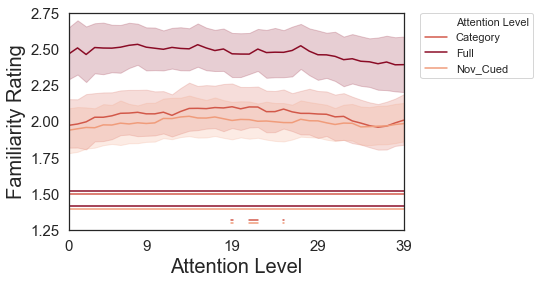

Experiment_2: Sliding Window - Same Category Images - Faces
[nan]
(1.0, 4.0)
(6.0, 15.0)


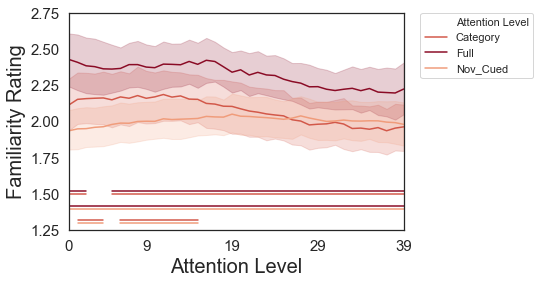

In [47]:
for key,label in zip(plot_data.keys(),['Experiment_1','Experiment_2']):
    
    print(label + ': Sliding Window - Same Category Images - Faces')
    
    data = plot_data[key]
    
    
    # plot ####################################
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Full', 'Nov_Cued', 'Category'])], # 'Category', # ci=None,
                    palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13], "Novel":"black"})
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylim=(1.25, 2.75))
    ax.set(xlim=(0, 39))
    
    
#     # ttest first vs last ####################
#     data = data[data['Attention Level'].isin(['Category','Full','Nov_Cued'])]
# #     first_window = data[data['Trial']<1].groupby(['Attention Level','Subject'], as_index=False).mean()
# #     last_window  = data[data['Trial']>38].groupby(['Attention Level','Subject'], as_index=False).mean()
# #     anova = pingouin.rm_anova(dv='value', within='Attention Level', subject='Subject', data=first_window)
# #     anova_last = pingouin.rm_anova(dv='value', within='Attention Level', subject='Subject', data=last_window)

#     for cat in ['Full', 'Category', 'Nov_Cued']:

#         dat = data[data['Attention Level']==cat]
#         first_window = dat[dat['Trial']<1].groupby(['Attention Level','Subject'], as_index=False).mean()
#         last_window  = dat[dat['Trial']>38].groupby(['Attention Level','Subject'], as_index=False).mean()
# #         anova = pingouin.rm_anova(dv='value', within='Attention Level', subject='Subject', data=first_window)
# #         anova_last = pingouin.rm_anova(dv='value', within='Attention Level
        
# #         t = scipy.stats.ttest_rel(list(first_window['value']), list(last_window['value']))
# #         print(cat)
# #         print(t)
# #         print()
    
    #ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Category','Nov_Cued'])#, related=False)
    #print(ttest_data[ttest_data['Attention Level']=='Nov_']['timepoint_t_truth'].unique())
    
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Nov_Cued') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    
    for x in ranges(index):
        print(x)
        
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.32, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[3])
            plt.axhline( y=1.3, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[5])
            
        plt.axhline( y=1.32, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[3])
        plt.axhline( y=1.3, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[5])
        
        
    # ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Category','Full'])
    #print(ttest_data[ttest_data['Attention Level']=='Category']['timepoint_t_truth'].unique())
    
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Category') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    for x in ranges(index):
        #print(x)
        
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.52, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[0])
            plt.axhline( y=1.5, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[3])
        
        
        plt.axhline( y=1.52, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[0])
        plt.axhline( y=1.5, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[3])
        
        
    # ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Nov_Cued','Full'])
    #print(ttest_data[ttest_data['Attention Level']=='Category']['timepoint_t_truth'].unique())
    
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Full') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    for x in ranges(index):
        #print(x)
        
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.42, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[0])
            plt.axhline( y=1.4, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[5])
        
        plt.axhline( y=1.42, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[0])
        plt.axhline( y=1.4, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[5])
        
    # plot settings & save ####################
    plt.grid(False)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xlabel('Attention Level',    fontsize = 20)
    plt.ylabel('Familiarity Rating', fontsize = 20)
    
    plt.xticks([0, 9, 19, 29, 39])
        
    plt.savefig(label+'_Full_Cat_NovCued.pdf')
    
    plt.show()
    

# Timecourse same location

Experiment_1: Sliding Window - Same Category Images - Faces
[True]
(0.0, 39.0)


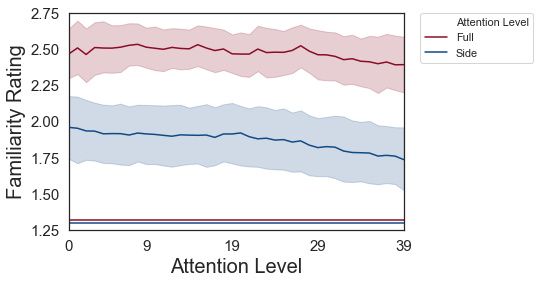

Experiment_2: Sliding Window - Same Category Images - Faces
[False]


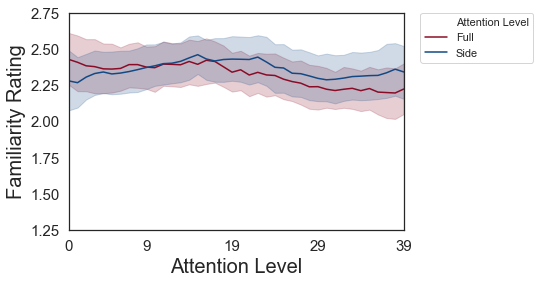

In [60]:
for key,label in zip(plot_data.keys(),['Experiment_1','Experiment_2']):
    
    print(label + ': Sliding Window - Same Category Images - Faces')
    
    data = plot_data[key]
    
    
    # plot ####################################
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Full', 'Side'])], # 'Category', # ci=None,
                    palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13], "Novel":"black"})
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylim=(1.25, 2.75))
    ax.set(xlim=(0, 39))
    
    
#     # ttest first vs last ####################
#     data = data[data['Attention Level'].isin(['Category','Full','Nov_Cued'])]
# #     first_window = data[data['Trial']<1].groupby(['Attention Level','Subject'], as_index=False).mean()
# #     last_window  = data[data['Trial']>38].groupby(['Attention Level','Subject'], as_index=False).mean()
# #     anova = pingouin.rm_anova(dv='value', within='Attention Level', subject='Subject', data=first_window)
# #     anova_last = pingouin.rm_anova(dv='value', within='Attention Level', subject='Subject', data=last_window)

#     for cat in ['Full', 'Category', 'Nov_Cued']:

#         dat = data[data['Attention Level']==cat]
#         first_window = dat[dat['Trial']<1].groupby(['Attention Level','Subject'], as_index=False).mean()
#         last_window  = dat[dat['Trial']>38].groupby(['Attention Level','Subject'], as_index=False).mean()
# #         anova = pingouin.rm_anova(dv='value', within='Attention Level', subject='Subject', data=first_window)
# #         anova_last = pingouin.rm_anova(dv='value', within='Attention Level
        
# #         t = scipy.stats.ttest_rel(list(first_window['value']), list(last_window['value']))
# #         print(cat)
# #         print(t)
# #         print()
    
    #ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Full','Side'])#, related=False)
    print(ttest_data[ttest_data['Attention Level']=='Side']['timepoint_t_truth'].unique())
    
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Side') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    
    for x in ranges(index):
        print(x)
        
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.32, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[0])
            plt.axhline( y=1.3, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[19])
            
        plt.axhline( y=1.32, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[0])
        plt.axhline( y=1.3, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[19])
    
    
        
    # plot settings & save ####################
    plt.grid(False)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xlabel('Attention Level',    fontsize = 20)
    plt.ylabel('Familiarity Rating', fontsize = 20)
    
    plt.xticks([0, 9, 19, 29, 39])
        
    plt.savefig(label+'_Full_Cat_NovCued.pdf')
    
    plt.show()
    

Experiment_1: Sliding Window - Same Category Images - Faces
[True]
(0.0, 39.0)


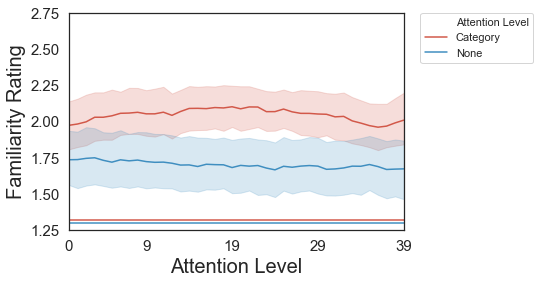

Experiment_2: Sliding Window - Same Category Images - Faces
[False True]
(30.0, 31.0)
(33.0, 35.0)
(37.0, 37.0)


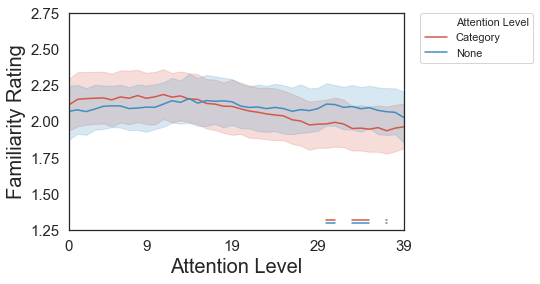

In [61]:
for key,label in zip(plot_data.keys(),['Experiment_1','Experiment_2']):
    
    print(label + ': Sliding Window - Same Category Images - Faces')
    
    data = plot_data[key]
    
    
    # plot ####################################
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Category', 'None'])], # 'Category', # ci=None,
                    palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
                            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13], "Novel":"black"})
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylim=(1.25, 2.75))
    ax.set(xlim=(0, 39))
    
    
#     # ttest first vs last ####################
#     data = data[data['Attention Level'].isin(['Category','Full','Nov_Cued'])]
# #     first_window = data[data['Trial']<1].groupby(['Attention Level','Subject'], as_index=False).mean()
# #     last_window  = data[data['Trial']>38].groupby(['Attention Level','Subject'], as_index=False).mean()
# #     anova = pingouin.rm_anova(dv='value', within='Attention Level', subject='Subject', data=first_window)
# #     anova_last = pingouin.rm_anova(dv='value', within='Attention Level', subject='Subject', data=last_window)

#     for cat in ['Full', 'Category', 'Nov_Cued']:

#         dat = data[data['Attention Level']==cat]
#         first_window = dat[dat['Trial']<1].groupby(['Attention Level','Subject'], as_index=False).mean()
#         last_window  = dat[dat['Trial']>38].groupby(['Attention Level','Subject'], as_index=False).mean()
# #         anova = pingouin.rm_anova(dv='value', within='Attention Level', subject='Subject', data=first_window)
# #         anova_last = pingouin.rm_anova(dv='value', within='Attention Level
        
# #         t = scipy.stats.ttest_rel(list(first_window['value']), list(last_window['value']))
# #         print(cat)
# #         print(t)
# #         print()
    
    #ttest at each timepoint #################
    ttest_data = timepoint_ttest(data, ['Category','None'])#, related=False)
    print(ttest_data[ttest_data['Attention Level']=='Category']['timepoint_t_truth'].unique())
    
    
    # lines w/ sig pval #######################
    index = ttest_data[(ttest_data['Attention Level']=='Category') & (ttest_data['timepoint_t_truth']==True)]['Trial'].tolist()
    index = set(index)
    
    
    for x in ranges(index):
        print(x)
        
        if x[0] == x[1]:
            x_new_0 = x[0]-.1
            x_new_1 = x[1]+.1

            plt.axhline( y=1.32, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[3])
            plt.axhline( y=1.3, xmin=x_new_0*(1/39), xmax=x_new_1*(1/39), color=palette[16])
            
        plt.axhline( y=1.32, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[3])
        plt.axhline( y=1.3, xmin=x[0]*(1/39), xmax=x[1]*(1/39), color=palette[16])
    
    
        
    # plot settings & save ####################
    plt.grid(False)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xlabel('Attention Level',    fontsize = 20)
    plt.ylabel('Familiarity Rating', fontsize = 20)
    
    plt.xticks([0, 9, 19, 29, 39])
        
    plt.savefig(label+'_Full_Cat_NovCued.pdf')
    
    plt.show()
    

In [ ]:
for key,label in zip(plot_data.keys(),['Experiment 1','Experiment 2']):
    
    print(label + ': Sliding Window - Same Side Images')
    
    data = plot_data[key]
    
    # plot
    ax = sb.lineplot(x='Trial',y='value', hue = 'Attention Level', 
                data = data[data['Attention Level'].isin(['Full', 'Side', 'Nov_Cued'])], # 'Category', # ci=None,
                    palette = {"Full": "crimson", "Category": "deeppink", "Nov_Cued":"magenta", 
                           "Side": "blue", "None": "dodgerblue", "Nov_Un":"skyblue"})
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set(ylim=(1.5, 2.8))
    plt.show()
    
    
    # ANOVA yields Significantly different Fam Ratings in both first and last sliding windows, in both cases
    
        # stats test
    data = data[data['Attention Level'].isin(['Full','Side','Nov_Cued'])] #'Category',
    first_window = data[data['Trial']<1].groupby(['Attention Level','Subject'], as_index=False).mean()
    last_window  = data[data['Trial']>38].groupby(['Attention Level','Subject'], as_index=False).mean()
    anova = pingouin.rm_anova(dv='value', within='Attention Level', subject='Subject', data=first_window)
    anova_last = pingouin.rm_anova(dv='value', within='Attention Level', subject='Subject', data=last_window)

    # show anova result
    print('ANOVA - familiarity ~ attn levels : first sliding window:')
    print()
    print(anova)
    print()
    print()
    print('ANOVA - familiarity ~ attn levels : last sliding window:')
    print()
    print(anova_last)
    
    print()
    print('T-TESTS : first window versus last window WITHING IMAGE TYPE ')
    print()
    
    # ttest first versus last window
    for cat in ['Full','Nov_Cued','Side']:

        d = data[data['Attention Level']==cat]
        first_window = d[d['Trial']<1].groupby(['Attention Level','Subject'], as_index=False).mean()
        last_window  = d[d['Trial']>38].groupby(['Attention Level','Subject'], as_index=False).mean()

        t = scipy.stats.ttest_rel(list(first_window['value']), list(last_window['value']))

        print('t-test, first window versus last window: '+cat)
        print(t)
        print()
        print()


### Serial Position Analysis

In [ ]:
exp1.head()

In [ ]:
exp2.head()

In [ ]:
def add_level(df, trials='block'):
    '''
    input: subject dataframe
    output: subject dataframe w/ Attention Level string for each Memory trial row
    '''
    for x in df.Run.unique():
        mask = df['Run']==x

        if trials == 'block':
            df[mask] = run_level(df[mask])
        elif trials == 'unique':
            df[mask] = run_level_unique(df[mask])

    return(df)


def run_level(df):
    '''
    input: df containing pres and mem from single run
    output: df with string in 'Attention Level' column in each Memory trial row
    '''
    #cued_cat = df[df['Trial Type']=='Presentation']['Cued Category'].tolist()[0]
    
    
    for index,row in df.iterrows():
        
        if row['Trial Type']=='Memory':
            mem_image = row['Memory Image']
            
            for cue in ['Cued ', 'Uncued ']:
                for cat in ['Face', 'Place']:
                    
                    if df.loc[df[cue+cat] == mem_image].shape[0]!=0:
                        
                        pres_trial = df.loc[df[cue+cat] == mem_image]['Trial'].item()
                        df['Pres Trial'][index] = pres_trial

#     mem_mask = df['Trial Type']=='Memory'
#     df.loc[mem_mask,'Pres Trial'] = df.loc[mem_mask,'Pres Trial'].fillna(np.nan)

    return(df)

# Add positions to mem images for SPC

In [35]:
exp1['Pres Trial'] = np.nan

In [36]:
total = []

for sub in [0]:
    
    print(sub)
    total.append(add_level(exp1[exp1['Subject']==sub]))
    
k = pd.concat(total)    

0


In [37]:
k['Pres Trial'].unique()

array([nan])

In [38]:
data = pd.concat(total)
data.to_csv('exp1_SPC')

In [39]:
# sb.lineplot(x='Pres Trial',y='Familiarity Rating', hue='Attention Level', data=data)

In [40]:
# data['Pres Trial']

In [41]:
exp1['Pres Trial'] = np.nan

In [55]:
# exp1

# Graveyard

In [43]:
    
#     # conduct anova on first and last window
#     first_window = data[data['Trial']<10].groupby(['Attention Level','Subject'], as_index=False).mean()
#     last_window  = data[data['Trial']>29].groupby(['Attention Level','Subject'], as_index=False).mean()
#     anova = pingouin.rm_anova(dv='value', within='Attention Level', subject='Subject', data=first_window)
#     anova_last = pingouin.rm_anova(dv='value', within='Attention Level', subject='Subject', data=last_window)
    
#     # show anova result
#     print(anova)
#     print(anova_last)

In [ ]:
def ROC_prop(df, rate, attn, novel='matched'):
    '''
    input: subject df
           rating - Familiarity score (float between 1.0 and 4.0)
           attn - at time of encoding (string)

    output: proportion of images encoded at ATTENTION LEVEL
            given a score of RATE or higher, sorted by
            CATEGORY (if category == True)
    '''

    # proportions
    combined = float(df.loc[(df['Attention Level'] == attn) 
                  & (df['Familiarity Rating'] >= rate)].shape[0])/(df.loc[(df['Attention Level'] == attn) 
                  & (df['Familiarity Rating'] > 0)].shape[0])

    if novel == 'all':
        # all novel images for desired ratings in both categories
        denom_f = df.loc[(df['Attention Level'] == attn) & (df['Familiarity Rating'] > 0)].shape[0]
        denom_p = denom_f

    else:
        if novel   == 'matched':
            f_nov,p_nov = 'Face','Place'
        elif novel == 'opposite':
            p_nov,f_nov = 'Place','Face'

        denom_p = df.loc[(df['Attention Level'] == attn) & (df['Category'] == p_nov) & (df['Familiarity Rating'] > 0)].shape[0]
        denom_f = (df.loc[(df['Attention Level'] == attn) & (df['Category'] == f_nov) & (df['Familiarity Rating'] > 0)].shape[0])

    if df.loc[(df['Attention Level'] == attn) & (df['Category'] == 'Face')].shape[0] > 0:
        face = float(df.loc[(df['Attention Level'] == attn) & (df['Familiarity Rating'] >= rate) & (df['Category'] == 'Face')].shape[0])/denom_f
    else:
        face = np.nan

    if df.loc[(df['Attention Level'] == attn) & (df['Category'] == 'Place')].shape[0] > 0:
        house = float(df.loc[(df['Attention Level'] == attn) & (df['Familiarity Rating'] >= rate) & (df['Category'] == 'Place')].shape[0])/denom_p
    else:
        house = np.nan

    props = [combined, face, house]
    return(props)



def ROC_data(df, novel='matched'):
    '''
    input: subject df
    output: list of three ROC proportion sets (list of dicts): 1) all images, 2) faces, 3) places
    '''

    ratings = [4.0, 3.0, 2.0, 1.0]
    ROC, ROC_f, ROC_h = {},{},{}

    # for each attention level
    for attn in ['Nov_Cued','Nov_Un', 'None', 'Side', 'Full', 'Category']:
        for idx,roc in enumerate([ROC, ROC_f, ROC_h]):
            roc[attn] = [0]

            # for each possible number rating
            for rate in ratings:
                roc[attn].append(ROC_prop(df, rate, attn, novel=novel)[idx])

    return(ROC, ROC_f, ROC_h)



def ROC_plot(ROC_data, save_out=False, save='ROC.pdf'):
    '''
    input: ROC proportions (dictionary)
    output: displays plot of ROC curve
    '''

    fig, ax = plt.subplots()

    for attn,color in zip(['Category', 'Full'],['purple','blue']): # , 'None', 'Side'],['purple','blue','orange','red']):
        ax.plot(ROC_data['Nov_Cued'], ROC_data[attn], '-o', label=attn, color=color)
        
    for attn,color in zip(['None', 'Side'],['orange','red']): # , 'None', 'Side'],['purple','blue','orange','red']):
        ax.plot(ROC_data['Nov_Un'], ROC_data[attn], '-o', label=attn, color=color)

    plt.legend(loc='upper left');
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    if save_out == True:
        plt.savefig(save)
    plt.show()

def ROC_df(df):

    '''
    input:  full df
    output: list of subject df's with run-wise ROC data
    '''

    subject_list = []

    for sub in df['Subject'].unique():
        subject=[]

        for run in df['Run'].unique():
            subject.append(ROC_data(df[(df['Run']==run) & (df['Subject']==sub)]))
        subject_list.append(subject)

    return(subject_list)


def AUC(x_vals, y_vals):
    '''
    input:
    x_vals - x values for ROC curve, arranged left to right (list of floats)
    y_vals - y values for ROC curve, index matched to x_vals (list of floats)

    output:
    Area under the curve (AUC)
    '''

    AUC = 0

    for i,(x,y) in enumerate(zip(x_vals, y_vals)):
        if i>0:
            x_delt = x - x_vals[i-1]
            y_delt = y - y_vals[i-1]
            AUC += (y_vals[i-1] * x_delt) + (.5 * x_delt * y_delt)

    return(AUC)

In [267]:
# palette

# palette = {"Full": palette[0], "Category": palette[3], "Nov_Cued":palette[5], 
#            "Side": palette[19], "None": palette[16], "Nov_Un":palette[13]}

# Reaction Time Plots

In [6]:
import seaborn as sb
exp1.columns

Index(['Unnamed: 0.1', 'Subject', 'Trial Type', 'Run', 'Cued Composite',
       'Uncued Composite', 'Cued Face', 'Cued Place', 'Uncued Face',
       'Uncued Place', 'Memory Image', 'Category', 'Cued Side',
       'Cued Category', 'Attention Reaction Time (s)',
       'Familiarity Reaction Time (s)', 'Familiarity Rating',
       'Attention Level', 'Cue Validity', 'Post Invalid Cue',
       'Pre Invalid Cue', 'Attention Button', 'Rating History',
       'Stimulus Onset', 'Stimulus End', 'Attention Probe'],
      dtype='object')

experiment 1
experiment 1


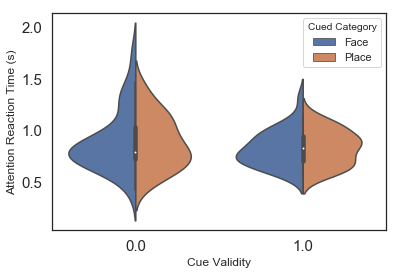

In [34]:
exp1_gr = exp1.groupby(['Subject','Cue Validity', 'Cued Category'], as_index=False).mean()

print('experiment 1')
sb.violinplot(x='Cue Validity', y='Attention Reaction Time (s)', hue='Cued Category', split=True, data=exp1_gr)

F = exp1[(exp1['Cue Validity']==1) & (exp1['Cued Category']=='Face')]


print('experiment 1')

experiment 1
experiment 1


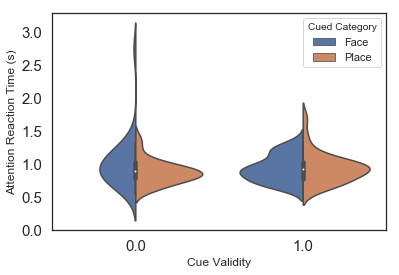

In [36]:
exp2_gr = exp2.groupby(['Subject','Cue Validity', 'Cued Category'], as_index=False).mean()

print('experiment 1')
sb.violinplot(x='Cue Validity', y='Attention Reaction Time (s)', hue='Cued Category', split=True, data=exp2_gr)

F = exp1[(exp1['Cue Validity']==1) & (exp1['Cued Category']=='Face')]
P = exp1[(exp1['Cue Validity']==1) & (exp1['Cued Category']=='Place')]

print('experiment 1')

In [44]:
anova = pingouin.rm_anova(dv='Attention Reaction Time (s)', within=['Cued Category'], subject='Subject', data=exp1_gr)
anova

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,Cued Category,1,29,0.03,0.86307,0.001,1.0


In [15]:
exp1.columns

Index(['Unnamed: 0.1', 'Subject', 'Trial Type', 'Run', 'Cued Composite',
       'Uncued Composite', 'Cued Face', 'Cued Place', 'Uncued Face',
       'Uncued Place', 'Memory Image', 'Category', 'Cued Side',
       'Cued Category', 'Attention Reaction Time (s)',
       'Familiarity Reaction Time (s)', 'Familiarity Rating',
       'Attention Level', 'Cue Validity', 'Post Invalid Cue',
       'Pre Invalid Cue', 'Attention Button', 'Rating History',
       'Stimulus Onset', 'Stimulus End', 'Attention Probe', 'Trial'],
      dtype='object')

In [27]:
exp1_gr = exp1.groupby(['Subject','Cue Validity'], as_index=False).mean()

scipy.stats.ttest_rel(exp1_gr[exp1_gr['Cue Validity']==0]['Attention Reaction Time (s)'], 
                            exp1_gr[exp1_gr['Cue Validity']==1]['Attention Reaction Time (s)'])

Ttest_relResult(statistic=2.726564495656624, pvalue=0.010744006694709042)

In [28]:
exp2_gr = exp2.groupby(['Subject','Cue Validity'], as_index=False).mean()

scipy.stats.ttest_rel(exp2_gr[exp2_gr['Cue Validity']==0]['Attention Reaction Time (s)'], 
                            exp2_gr[exp2_gr['Cue Validity']==1]['Attention Reaction Time (s)'])

Ttest_relResult(statistic=-0.015703450175793242, pvalue=0.9875785155263901)

# Face Versus Scene

In [54]:
for exp,label in zip([exp1, exp2],['exp 1','exp 2']):
    f_p = exp.groupby(['Category', 'Subject'], as_index=False).mean()
    print(label)
    print(scipy.stats.ttest_rel(f_p[f_p['Category']=='Place']['Familiarity Rating'], f_p[f_p['Category']=='Face']['Familiarity Rating']))
    print()

exp 1
Ttest_relResult(statistic=2.0422902656121815, pvalue=0.0503089403934693)

exp 2
Ttest_relResult(statistic=1.9760802060698364, pvalue=0.057727605976210926)



In [65]:
# exp1.columns

In [76]:
exp1_grp = exp1.groupby(['Subject','Cue Validity'], as_index=False).mean()
exp2_grp = exp2.groupby(['Subject','Cue Validity'], as_index=False).mean()

listies = []

for d in [exp1_grp, exp2_grp]:
    a = []
    b = []
    ls = []
    for s in d['Subject'].unique():
        a = d[(d['Subject']==s) & (d['Cue Validity']==1)]['Attention Reaction Time (s)'].item()
        b = d[(d['Subject']==s) & (d['Cue Validity']==0)]['Attention Reaction Time (s)'].item()
        ls.append(a-b)
        
    listies.append(ls)


In [81]:
scipy.stats.ttest_ind(listies[0], listies[1])

Ttest_indResult(statistic=-1.816503860821897, pvalue=0.07446168516704972)

-0.11657533380720353